In [19]:
import torch
import torch.nn as nn
import pandas as pd
import ast
import os
import pickle
import itertools
import copy
import json
from sklearn.metrics import (
    classification_report,
    multilabel_confusion_matrix,
    hamming_loss,
    jaccard_score,
    accuracy_score,
    precision_recall_fscore_support
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    TrainingArguments,
    Trainer
)

from peft import LoraConfig, get_peft_model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from datasets import Dataset
from safetensors.torch import load_file

In [10]:
#preprocess imdb dataset

def preprocess_imdb(
    input_csv: str,
    output_csv: str = "imdb_overview_genres_clean.csv",
    sample_size: int = 5000,
    random_state: int = 42
):
    """
    Preprocess IMDB dataset:
    - Keep only overview and genres
    - Remove NaN and empty rows
    - Normalize genres into multi-label format (A|B|C)
    - Randomly sample N entries
    - Save cleaned dataset to CSV
    """

    # Load dataset
    df = pd.read_csv(input_csv)

    # Select relevant columns
    df = df[["Overview", "Generes"]].copy()
    df.columns = ["overview", "genres"]

    # Drop NaN
    df.dropna(inplace=True)

    # Remove empty strings
    df = df[
        (df["overview"].str.strip() != "") &
        (df["genres"].str.strip() != "")
    ]

    # Normalize genre format: "Drama, Action" → "Drama|Action"
    df["genres"] = df["genres"].apply(
        lambda x: "|".join([g.strip() for g in x.split(",")])
    )

    # Reset index before sampling
    df.reset_index(drop=True, inplace=True)

    # 🔹 Random sampling
    if sample_size is not None and sample_size < len(df):
        df = df.sample(
            n=sample_size,
            random_state=random_state
        ).reset_index(drop=True)

    # Save cleaned dataset
    df.to_csv(output_csv, index=False)

    print("Preprocessing selesai.")
    print(f"Total data akhir: {len(df)}")
    print(f"File disimpan di: {output_csv}")

    return df
INPUT_PATH = "25k IMDb movie Dataset.csv"
OUTPUT_PATH = "imdb_overview_genres_clean.csv"

preprocess_imdb(
    input_csv=INPUT_PATH,
    output_csv=OUTPUT_PATH,
    sample_size=5000
)


Preprocessing selesai.
Total data akhir: 5000
File disimpan di: imdb_overview_genres_clean.csv


,overview,genres
0,The lives of two strangers and their young chi...,['Comedy'|'Drama'|'Romance']
1,A young gangster and his uncle attempt to outw...,['Action']
2,Two best friends set out to rescue their pal a...,['Animation'|'Adventure'|'Comedy']
3,An escort-service owner uses his girls to get ...,['Biography'|'Drama']
4,An F.B.I. Agent goes undercover to catch a gan...,['Action'|'Crime'|'Thriller']
...,...,...
4995,A drug kingpin is released from prison and see...,['Crime'|'Thriller']
4996,"As her world is shrouded in darkness, a young ...",['Animation'|'Adventure'|'Fantasy']
4997,The suite of the New Adventures of Aladin.,['Comedy'|'Fantasy']
4998,Young Jim Hawkins is torn between his loyalty ...,['Adventure'|'Family']


In [9]:
# Load cleaned dataset
DATA_PATH = "imdb_overview_genres_clean.csv"

df = pd.read_csv(DATA_PATH)
# df["genres"] = df["genres"].apply(lambda x: x.split("|"))
df["genres"] = df["genres"].str.replace("|", ",")
df["genres"] = df["genres"].str.replace("'",'"')
df["genres"] = df["genres"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [10]:
df["genres"] 

0              [Comedy, Drama, Romance]
1                              [Action]
2        [Animation, Adventure, Comedy]
3                    [Biography, Drama]
4             [Action, Crime, Thriller]
                     ...               
4995                  [Crime, Thriller]
4996    [Animation, Adventure, Fantasy]
4997                  [Comedy, Fantasy]
4998                [Adventure, Family]
4999          [Action, Drama, Thriller]
Name: genres, Length: 5000, dtype: object

In [11]:
# Multi-label binarization
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df["genres"])

NUM_LABELS = labels.shape[1]
print("Jumlah genre:", NUM_LABELS)
print("Genre:", mlb.classes_)


Jumlah genre: 23
Genre: ['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime' 'Drama'
 'Family' 'Fantasy' 'Film-Noir' 'Game-Show' 'History' 'Horror' 'Music'
 'Musical' 'Mystery' 'Reality-TV' 'Romance' 'Sci-Fi' 'Sport' 'Thriller'
 'War' 'Western']


In [12]:
# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    df["overview"], labels, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


In [13]:
# Tokenizer initialization
MODEL_NAME = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)

tokenizer.pad_token = tokenizer.eos_token


In [14]:
# Dataset preparation
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

def build_dataset(texts, labels):
    ds = Dataset.from_dict({
        "text": texts.tolist(),
        "labels": labels
    })
    return ds.map(tokenize, batched=True)

train_ds = build_dataset(X_train, y_train)
val_ds   = build_dataset(X_val, y_val)
test_ds  = build_dataset(X_test, y_test)


Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

In [15]:
# Model definition
class QwenForMultiLabelClassification(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(
            base_model.config.hidden_size,
            num_labels
        )

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        last_hidden = outputs.last_hidden_state[:, -1, :]
        logits = self.classifier(last_hidden)

        loss = None
        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())

        return {"loss": loss, "logits": logits}


In [16]:
# Load base model and apply LoRA
base_model = AutoModel.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

base_model = get_peft_model(base_model, lora_config)
model = QwenForMultiLabelClassification(base_model, NUM_LABELS)


In [ ]:
# Hyperparameter grid
learning_rates = [1e-4,5e-4,1e-3]
epochs_list = [4,8]

grid = list(itertools.product(learning_rates, epochs_list))
def extract_training_history(log_history):
    rows = []

    for log in log_history:
        if "epoch" not in log:
            continue

        rows.append({
            "epoch": log.get("epoch"),
            "train_loss": log.get("loss"),
            "eval_loss": log.get("eval_loss"),
            "eval_f1_micro": log.get("eval_f1_micro"),
            "learning_rate": log.get("learning_rate")
        })

    df = pd.DataFrame(rows)

    # Merge train + eval logs per epoch
    df = df.groupby("epoch", as_index=False).first()

    return df


In [ ]:
# Run experiments over hyperparameter grid
all_results = []

BASE_EXPERIMENT_DIR = "./experiments"
os.makedirs(BASE_EXPERIMENT_DIR, exist_ok=True)

for lr, epochs in grid:
    run_name = f"lr={lr}_ep={epochs}"
    run_dir = os.path.join(BASE_EXPERIMENT_DIR, run_name)

    print(f"\n{'='*60}")
    print(f"TRAINING: {run_name}")
    print(f"{'='*60}")

    os.makedirs(run_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=os.path.join(run_dir, "trainer_output"),
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_micro",
        fp16=torch.cuda.is_available(),
        report_to="none",
        no_cuda=True
    )

    model_run = copy.deepcopy(model)

    trainer = Trainer(
        model=model_run,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()

    # 🔹 SAVE TRAINING HISTORY (PER RUN)
    history_df = extract_training_history(trainer.state.log_history)
    history_df.to_csv(
        os.path.join(run_dir, "training_history.csv"),
        index=False
    )
    print("✓ Training history saved")

    # ==========================================================
    # SAVE TRAINED MODEL AND ARTIFACTS (PER YOUR EXACT FORMAT)
    # ==========================================================

    # 1. Save LoRA adapter
    saved_model_dir = os.path.join(run_dir, "saved_model")
    os.makedirs(saved_model_dir, exist_ok=True)

    model_run.base_model.save_pretrained(
        os.path.join(saved_model_dir, "adapter_model")
    )
    print("✓ LoRA adapter saved")

    # 2. Save classifier head
    classifier_state = {
        "classifier": model_run.classifier.state_dict()
    }
    torch.save(
        classifier_state,
        os.path.join(saved_model_dir, "classifier_head.pt")
    )
    print("✓ Classifier head saved")

    # 3. Save tokenizer
    tokenizer_dir = os.path.join(run_dir, "saved_tokenizer")
    tokenizer.save_pretrained(tokenizer_dir)
    print("✓ Tokenizer saved")

    # 4. Save MultiLabelBinarizer
    with open(os.path.join(run_dir, "mlb.pkl"), "wb") as f:
        pickle.dump(mlb, f)
    print("✓ MultiLabelBinarizer saved")

    # 5. Save model configuration
    config_info = {
        "model_name": MODEL_NAME,
        "num_labels": NUM_LABELS,
        "learning_rate": lr,
        "epochs": epochs,
        "genres": mlb.classes_.tolist()
    }

    with open(os.path.join(run_dir, "model_config.pkl"), "wb") as f:
        pickle.dump(config_info, f)
    print("✓ Model config saved")

    # 6. Save evaluation metrics
    with open(os.path.join(run_dir, "eval_metrics.pkl"), "wb") as f:
        pickle.dump(eval_result, f)

    # Collect results for comparison table
    all_results.append({
        "model_name": run_name,
        "learning_rate": lr,
        "epochs": epochs,
        **eval_result
    })

    print(f"✓ ALL ARTIFACTS SAVED FOR {run_name}")



TRAINING: lr=0.001_ep=8


c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\transformers\training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,No log,0.206816,0.520238,0.343337
2,No log,0.203226,0.560048,0.364458
3,0.199800,0.214594,0.541477,0.371524
4,0.199800,0.245288,0.565809,0.397245
5,0.112700,0.292039,0.558949,0.391593
6,0.112700,0.414589,0.560571,0.382136
7,0.028300,0.453585,0.569559,0.383064
8,0.028300,0.458911,0.564828,0.378731


c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in 

c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


✓ Training history saved
✓ LoRA adapter saved
✓ Classifier head saved
✓ Tokenizer saved
✓ MultiLabelBinarizer saved
✓ Model config saved
✓ ALL ARTIFACTS SAVED FOR lr=0.001_ep=8


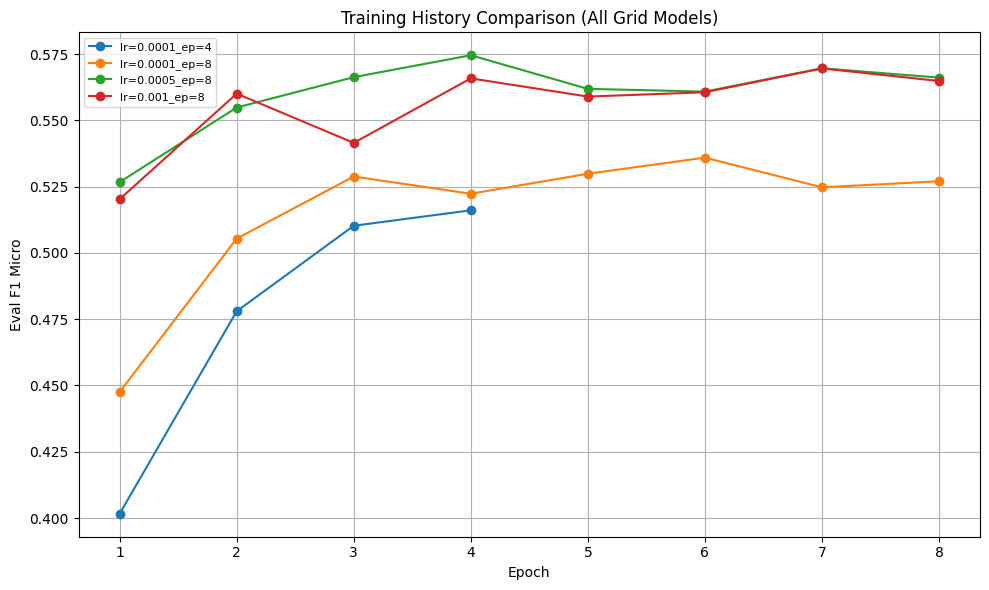

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

BASE_EXPERIMENT_DIR = "./experiments"
all_histories = []

# Load all training histories
for run_name in sorted(os.listdir(BASE_EXPERIMENT_DIR)):
    history_path = os.path.join(
        BASE_EXPERIMENT_DIR,
        run_name,
        "training_history.csv"
    )
    if os.path.isfile(history_path):
        df = pd.read_csv(history_path)
        df["model_name"] = run_name
        all_histories.append(df)

# Combine into one DataFrame
combined_df = pd.concat(all_histories, ignore_index=True)

# ===============================
# PLOT ALL MODELS IN ONE GRAPH
# ===============================
plt.figure(figsize=(10, 6))
for model_name, group in combined_df.groupby("model_name"):
    # Sort by epoch and clean up the data
    group = group.sort_values("epoch")
    group = group.dropna(subset=["eval_f1_micro"])
    group = group.drop_duplicates(subset=["epoch"], keep="last")
    
    plt.plot(
        group["epoch"],
        group["eval_f1_micro"],
        marker="o",
        label=model_name
    )

plt.xlabel("Epoch")
plt.ylabel("Eval F1 Micro")
plt.title("Training History Comparison (All Grid Models)")
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# if there is event that make model unsved then find best checkpoint across the unsaved experiments so it can be saved separately

# ===============================
# DEFINE EXPERIMENT DIRECTORY
# ===============================
run_dir = "./experiments/lr=0.0005_ep=8"
trainer_output = os.path.join(run_dir, "trainer_output")

# ===============================
# FIND BEST CHECKPOINT
# ===============================
best_ckpt = None
best_f1 = -1.0

for checkpoint_dir in os.listdir(trainer_output):
    if not checkpoint_dir.startswith("checkpoint-"):
        continue
    
    state_path = os.path.join(trainer_output, checkpoint_dir, "trainer_state.json")
    if not os.path.exists(state_path):
        continue
    
    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)
    
    best_metric = state.get("best_metric")
    if best_metric and best_metric > best_f1:
        best_f1 = best_metric
        best_ckpt = os.path.join(trainer_output, checkpoint_dir)

print(f"Best checkpoint: {best_ckpt}")
print(f"Best eval_f1_micro: {best_f1}")

# ===============================
# LOAD AND SAVE BEST MODEL
# ===============================
saved_model_dir = os.path.join(run_dir, "saved_model")
saved_tokenizer_dir = os.path.join(run_dir, "saved_tokenizer")

# Load model from best checkpoint
model_run = copy.deepcopy(model)
state_dict = load_file(os.path.join(best_ckpt, "model.safetensors"))
model_run.load_state_dict(state_dict, strict=False)
print("✓ Model weights loaded from checkpoint")

# Create directories
os.makedirs(saved_model_dir, exist_ok=True)
os.makedirs(saved_tokenizer_dir, exist_ok=True)

# Save LoRA adapter
model_run.base_model.save_pretrained(saved_model_dir)
print(f"✓ LoRA adapter saved to '{saved_model_dir}'")

# Save classifier head
torch.save(
    {"classifier": model_run.classifier.state_dict()},
    os.path.join(saved_model_dir, "classifier_head.pt")
)
print("✓ Classifier head saved")

# Save tokenizer
tokenizer.save_pretrained(saved_tokenizer_dir)
print("✓ Tokenizer saved")

# Save MultiLabelBinarizer
with open(os.path.join(run_dir, "mlb.pkl"), "wb") as f:
    pickle.dump(mlb, f)
print("✓ MultiLabelBinarizer saved")

# Save model configuration
config_info = {
    "num_labels": NUM_LABELS,
    "model_name": MODEL_NAME,
    "genres": mlb.classes_.tolist()
}
with open(os.path.join(run_dir, "model_config.pkl"), "wb") as f:
    pickle.dump(config_info, f)
print("✓ Model config saved")

print("\n" + "=" * 60)
print("ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("=" * 60)

Best checkpoint: ./experiments/lr=0.0005_ep=8\trainer_output\checkpoint-1095
Best eval_f1_micro: 0.5745288406624786
✓ Model weights loaded from checkpoint
✓ LoRA adapter saved to './experiments/lr=0.0005_ep=8\saved_model'
✓ Classifier head saved
✓ Tokenizer saved
✓ MultiLabelBinarizer saved
✓ Model config saved

ALL ARTIFACTS SAVED SUCCESSFULLY!


In [ ]:


# Metric computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    logits = torch.from_numpy(logits)
    labels = torch.from_numpy(labels)

    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).int()

    return {
        "f1_micro": f1_score(
            labels.numpy(), preds.numpy(), average="micro"
        ),
        "f1_macro": f1_score(
            labels.numpy(), preds.numpy(), average="macro"
        ),
    }
# Training arguments
training_args = TrainingArguments(
    output_dir="./qwen3_genre_results",
    eval_strategy="epoch",    
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    fp16=torch.cuda.is_available(),
    report_to="none",
    no_cuda=True
)

# Trainer initialization and training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

trainer.train()


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
test_results = trainer.evaluate(test_ds)
print(test_results)

{'eval_loss': 0.10354158282279968, 'eval_f1_micro': 0.23468161794152984, 'eval_f1_macro': 0.0743633273050382, 'eval_runtime': 1079.4795, 'eval_samples_per_second': 0.695, 'eval_steps_per_second': 0.087, 'epoch': 4.0}


c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
# SAVE TRAINED MODEL AND ARTIFACTS

# Create directory for saved model
os.makedirs("./saved_model", exist_ok=True)

# 1. Save the LoRA adapter (base_model)
model.base_model.save_pretrained("./saved_model")
print("✓ LoRA adapter saved to './saved_model'")

# 2. Save the classifier head separately
classifier_state = {
    'classifier': model.classifier.state_dict()
}
torch.save(classifier_state, "./saved_model/classifier_head.pt")
print("✓ Classifier head saved to './saved_model/classifier_head.pt'")

# 3. Save the tokenizer
tokenizer.save_pretrained("./saved_tokenizer")
print("✓ Tokenizer saved to './saved_tokenizer'")

# 4. Save the MultiLabelBinarizer
with open("mlb.pkl", "wb") as f:
    pickle.dump(mlb, f)
print("✓ MultiLabelBinarizer saved to 'mlb.pkl'")

# 5. Save model configuration info
config_info = {
    "num_labels": NUM_LABELS,
    "model_name": MODEL_NAME,
    "genres": mlb.classes_.tolist()
}

with open("model_config.pkl", "wb") as f:
    pickle.dump(config_info, f)
print("✓ Model config saved to 'model_config.pkl'")

print("\n" + "="*60)
print("ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*60)
print("\nSaved files:")
print("  - ./saved_model/ (LoRA adapter + classifier head)")
print("  - ./saved_tokenizer/ (tokenizer)")
print("  - mlb.pkl (MultiLabelBinarizer)")
print("  - model_config.pkl (configuration)")

✓ LoRA adapter saved to './saved_model'
✓ Classifier head saved to './saved_model/classifier_head.pt'
✓ Tokenizer saved to './saved_tokenizer'
✓ MultiLabelBinarizer saved to 'mlb.pkl'
✓ Model config saved to 'model_config.pkl'

ALL ARTIFACTS SAVED SUCCESSFULLY!

Saved files:
  - ./saved_model/ (LoRA adapter + classifier head)
  - ./saved_tokenizer/ (tokenizer)
  - mlb.pkl (MultiLabelBinarizer)
  - model_config.pkl (configuration)
